In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import re
import numba as nb
import h5py
import math
import simulate_mri as simri
import h5py

plt.rcParams['figure.figsize'] = [10, 10]

base_path = '/home/turbotage/Documents/4DRecon/'
base_path_results = '/home/turbotage/Documents/4DRecon/results/'

In [2]:
true_image, vessel_mask, smaps = simri.load_true_and_smaps(base_path)

vessel_values_true = true_image[...,vessel_mask]

restricted_vessel_mask = np.zeros_like(vessel_mask)
restricted_vessel_mask[:,:,35] = vessel_mask[:,:,35]

vm_idx = np.where(vessel_mask)
res_vm_idx = np.where(restricted_vessel_mask)

restricted_index_arr = []
for i in range(res_vm_idx[0].shape[0]):
    index = np.where(np.stack([
        res_vm_idx[0][i] == vm_idx[0], 
        res_vm_idx[1][i] == vm_idx[1], 
        res_vm_idx[2][i] == vm_idx[2]]).all(axis=0))[0].item()

    restricted_index_arr.append(index)
restricted_index_arr = np.array(restricted_index_arr)
del vm_idx, res_vm_idx, i, index 

vessel_values_true_restricted = true_image[...,restricted_vessel_mask]


In [3]:
with h5py.File(base_path + 'reconed_full.h5', 'r') as f:
    reconned_full = f['image'][:]

vessel_values_full = reconned_full[...,vessel_mask]
vessel_values_full_restricted = reconned_full[...,restricted_vessel_mask]

del reconned_full

In [4]:
def errstr(w, l, start_method, additional_str=""):
    return f"err_w{w:.2e}_l{l:.2e}_{start_method}{additional_str}.h5"

def errs(w, l, start_method, additional_str=""):
    with h5py.File(base_path_results + errstr(w, l, start_method, additional_str), 'r') as f:
        err_rel = f['err_rel'][:]
        err_max = f['err_max'][:]
        vessel_values = f['vessel_values'][:]
    return err_rel, err_max, vessel_values

def imgs(w, l, start_method, additional_str=""):
    imgs = []
    with h5py.File(base_path_results + errstr(w, l, start_method, additional_str), 'r') as f:
        keys = list(f.keys())
        for key in keys:
            m = re.findall(r'img_(\d+)', key)
            if len(m) != 0:
                imgs.append(f[key][:])
    return imgs


In [5]:
@nb.jit(nopython=True, cache=True, nogil=True)
def constant_from_venc(venc):
	return (np.pi / (venc * math.sqrt(3)))

@nb.jit(nopython=True, cache=True, nogil=True)
def get_encode_matrix(k):
	Emat = k * np.array(
		[
			#[ 0,  0,  0],
			[-1, -1, -1],
			[ 1,  1, -1],
			[ 1, -1,  1],
			[-1,  1,  1]
		], dtype=np.float32)
	return Emat

@nb.jit(nopython=True, parallel=True, cache=True, nogil=True)
def enc_to_vel(voxvals, venc):
	Emat = get_encode_matrix(constant_from_venc(venc))
	pEmat = np.linalg.pinv(Emat).astype(np.float32)

	vels = np.empty((voxvals.shape[0], 20, 3, voxvals.shape[-1]), dtype=np.float32)
	for iter in range(voxvals.shape[0]):
		for frame in nb.prange(20):
			vv = voxvals[iter,frame,...]
			vv *= np.exp(-1j*np.angle(vv[0,...]))
			vv = np.angle(vv)
			vels[iter,frame,...] = pEmat @ vv[1:,...]
				
	return vels


In [6]:
#@nb.jit(nopython=True, parallel=True, cache=True, nogil=True)
def voxel_averaged_speeds_phases(vessel_values = np.empty((1,1,1,1), dtype=np.complex64)):

    vels = enc_to_vel(vessel_values, 1100)
    phases = np.angle(vessel_values)

    vx = np.mean(vels[:,:,0,:], axis=2)
    vy = np.mean(vels[:,:,1,:], axis=2)
    vz = np.mean(vels[:,:,2,:], axis=2)

    speeds = np.mean(np.sqrt(np.sum(np.square(vels), axis=2)), axis=2)
    speeds_plane = np.sqrt(np.square(vx) + np.square(vy) + np.square(vz))

    p0 = np.mean(phases[:,:,0,:], axis=2)
    p1 = np.mean(phases[:,:,1,:], axis=2)
    p2 = np.mean(phases[:,:,2,:], axis=2)
    p3 = np.mean(phases[:,:,3,:], axis=2)
    p4 = np.mean(phases[:,:,4,:], axis=2)

    return [speeds, speeds_plane, vx, vy, vz], [p0, p1, p2, p3, p4]

def correctly_reshape(vessel_values):
    if vessel_values.shape[1] == 100:
        return vessel_values.reshape(vessel_values.shape[0], 20, 5, vessel_values.shape[-1])
    elif vessel_values.shape[0] == 100:
        return vessel_values.reshape(20, 5, vessel_values.shape[-1])[None,...]


In [7]:
vinfo_full, pinfo_full = voxel_averaged_speeds_phases(vessel_values_full[None,...].repeat(20, axis=0)[None,...])
vinfo_full_restricted, pinfo_full_restricted = voxel_averaged_speeds_phases(vessel_values_full_restricted[None,...].repeat(20, axis=0)[None,...])

In [8]:
#vels = enc_to_vel(vessel_values_true[None,...], 1100)

vinfo_true, pinfo_true = voxel_averaged_speeds_phases(vessel_values_true[None,...])
vinfo_true_restricted, pinfo_true_restricted = voxel_averaged_speeds_phases(vessel_values_true[:,:,restricted_index_arr][None,...])

In [9]:
def all_vessel_values(p, l, start_method):
    _, _, vessel_values = errs(p, l, start_method)

    vessel_values_restricted = vessel_values[:,:,restricted_index_arr]
    vessel_values_restricted = correctly_reshape(vessel_values_restricted)
    vinfo_restricted, pinfo_restricted = voxel_averaged_speeds_phases(vessel_values_restricted)

    vessel_values = correctly_reshape(vessel_values)
    vinfo, pinfo = voxel_averaged_speeds_phases(vessel_values)

    return vinfo_restricted, pinfo_restricted, vinfo, pinfo


In [10]:
lambdas = [1.0, 5e-1, 2e-1, 1e-1, 5e-2, 1e-2, 1e-3, 1e-4]

vp_infos_mean = []
vp_infos_diff = []
vp_infos_zero = []

for l in lambdas:
    vp_infos_mean.append(all_vessel_values(0.5, l, 'mean'))
    vp_infos_diff.append(all_vessel_values(0.5, l, 'diff'))
    vp_infos_zero.append(all_vessel_values(0.5, l, 'zero'))


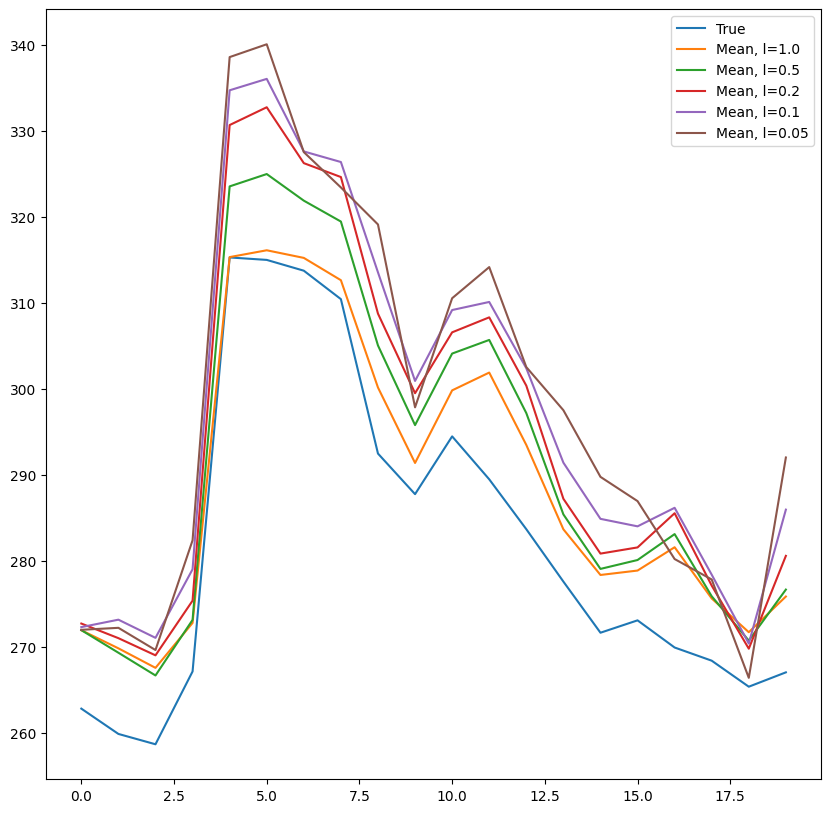

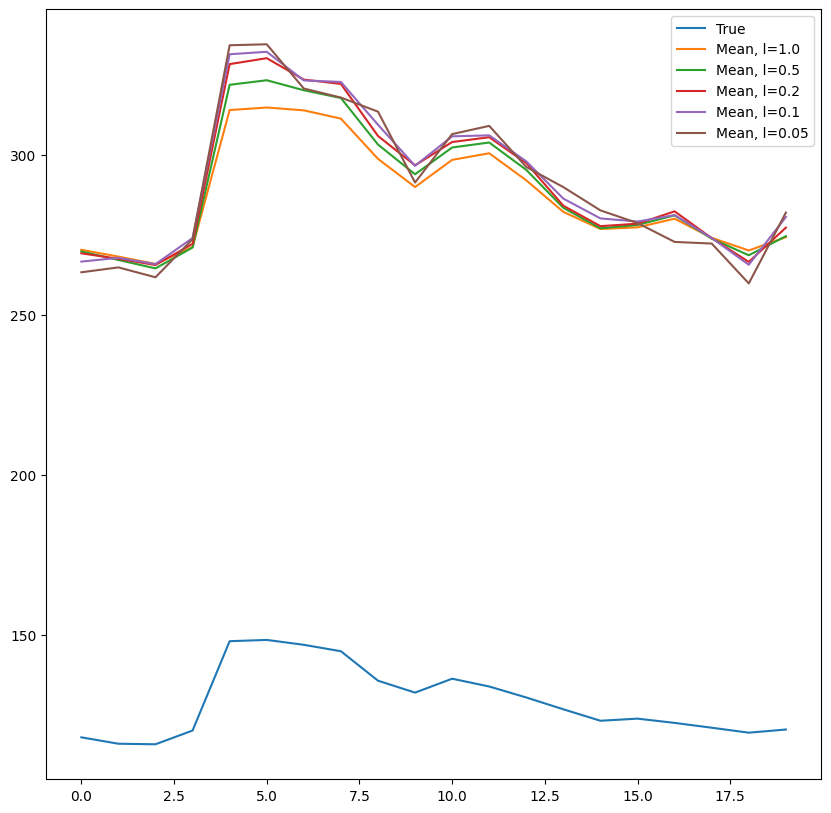

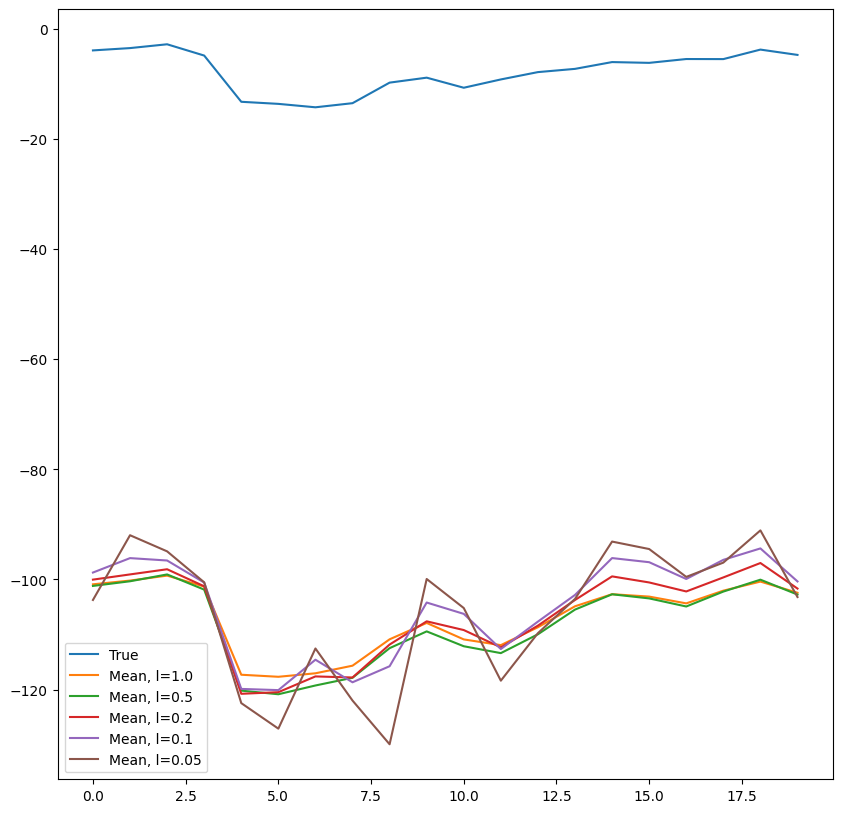

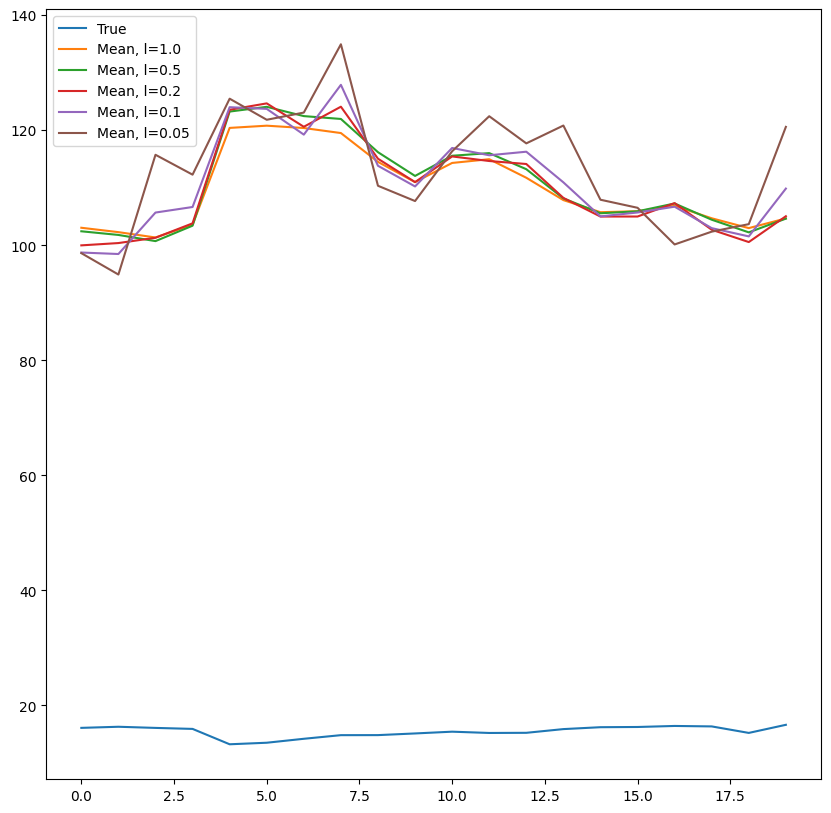

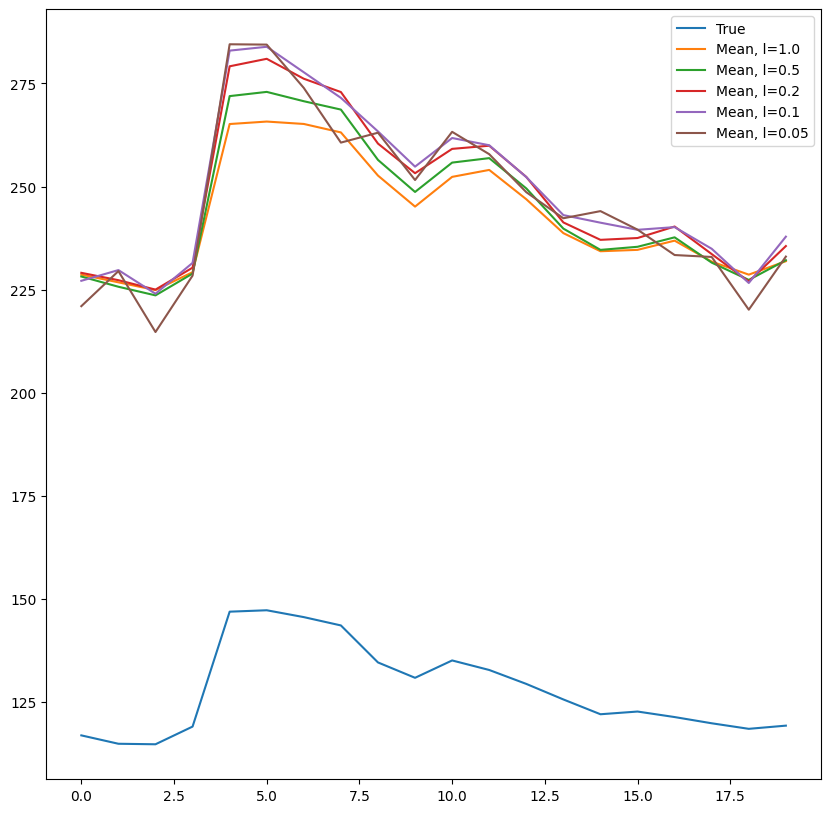

In [13]:
for typei in range(5):
    plt.figure()

    plt.plot(vinfo_true_restricted[typei][0], label="True")

    for li, l in enumerate(lambdas[:-3]):
        vpi = vp_infos_mean[li][0][typei][300]
        plt.plot(vpi, label=f"Mean, l={l}")

    plt.legend()
    plt.show()

NameError: name 'vinfo' is not defined

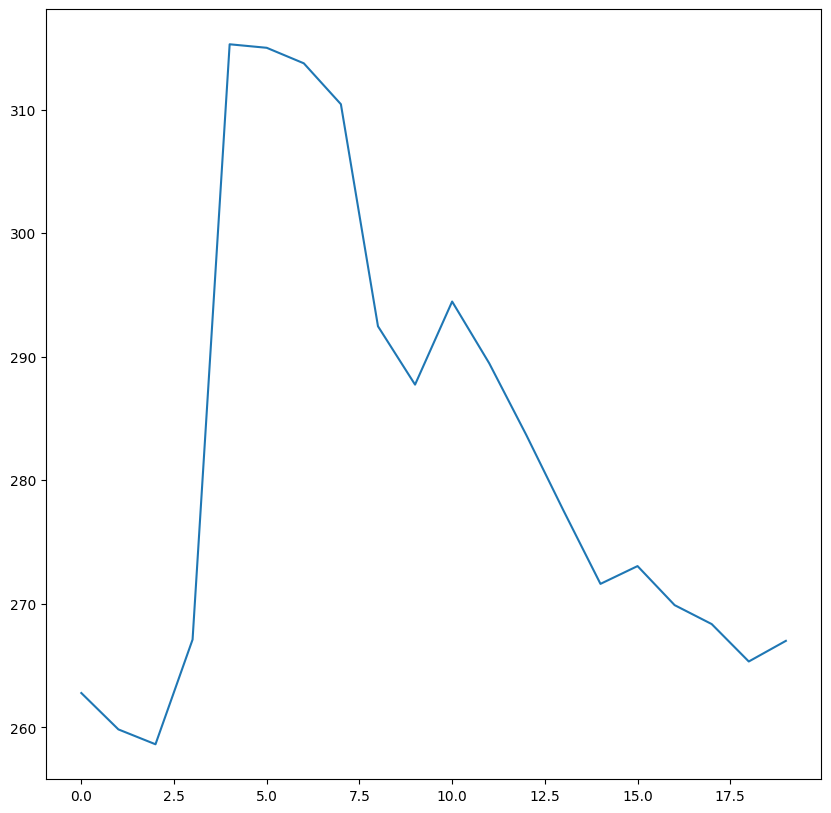

In [12]:
for i in range(5):
    plt.plot(vinfo_true[i][0], label="True")

    for iter in range(0, vinfo[0].shape[0], 300):
        plt.plot(vinfo[i][iter], label=f"Iter {iter}")

    print(vinfo_true[i][0][0])
    print(np.trapz(vinfo[i][300])/20)

    plt.legend()
    plt.show()

In [ ]:
def lpnorm(values, divisor=1, l=1):
    errs = []
    if l==1:
        for i in range(values.shape[0]):
            errs.append(np.trapz(np.abs(values[i]), axis=0) / divisor)
    elif i==2:
        for i in range(values.shape[0]):
            errs.append(np.trapz(np.square(np.abs(values[i])), axis=0) / divisor)
    return errs

In [ ]:
lamda = [1.0, 5e-1, 2e-1, 1e-1, 1e-2, 1e-3, 1e-4]

err_list = []

divisor = np.trapz(vinfo_true_restricted[0])

for l in lamda:
    _, _, vessel_values = errs(0.5, l, "mean")
    vessel_values_restricted = vessel_values[:,:,restricted_index_arr]
    vessel_values_restricted = correctly_reshape(vessel_values_restricted)
    vinfo_restricted, pinfo_restricted = voxel_averaged_speeds_phases(vessel_values_restricted)

    err_list.append(lpnorm(vinfo_restricted[0] - vinfo_true_restricted[0], divisor=divisor, l=1))


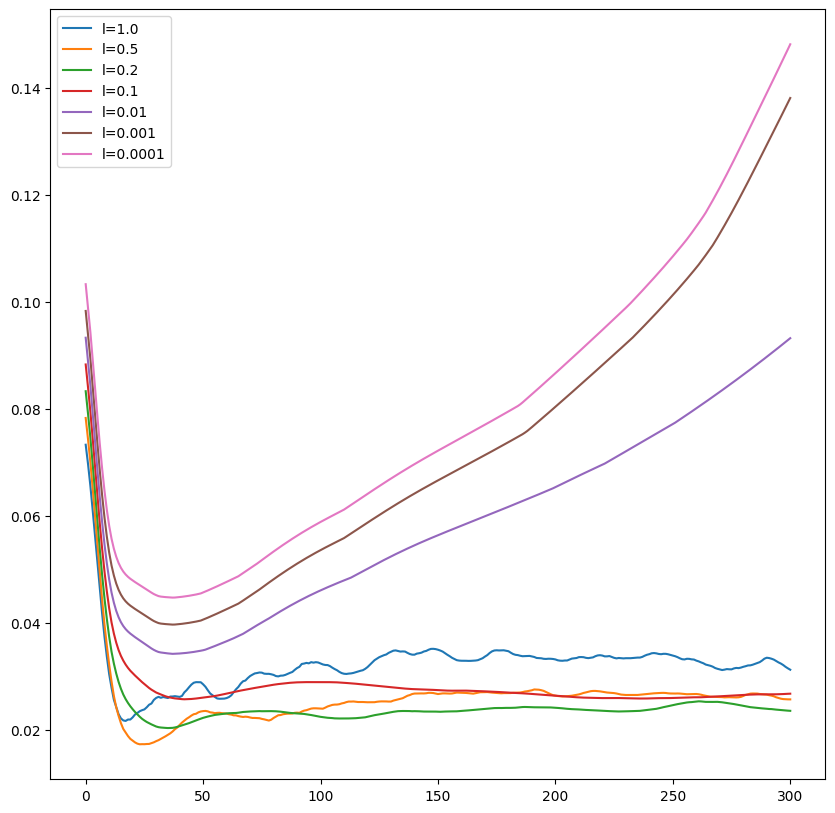

In [ ]:
plt.figure()
for i, err in enumerate(err_list):
    plt.plot(np.array(err)+i*0.005, label=f"l={lamda[i]}")

plt.legend()
plt.show()

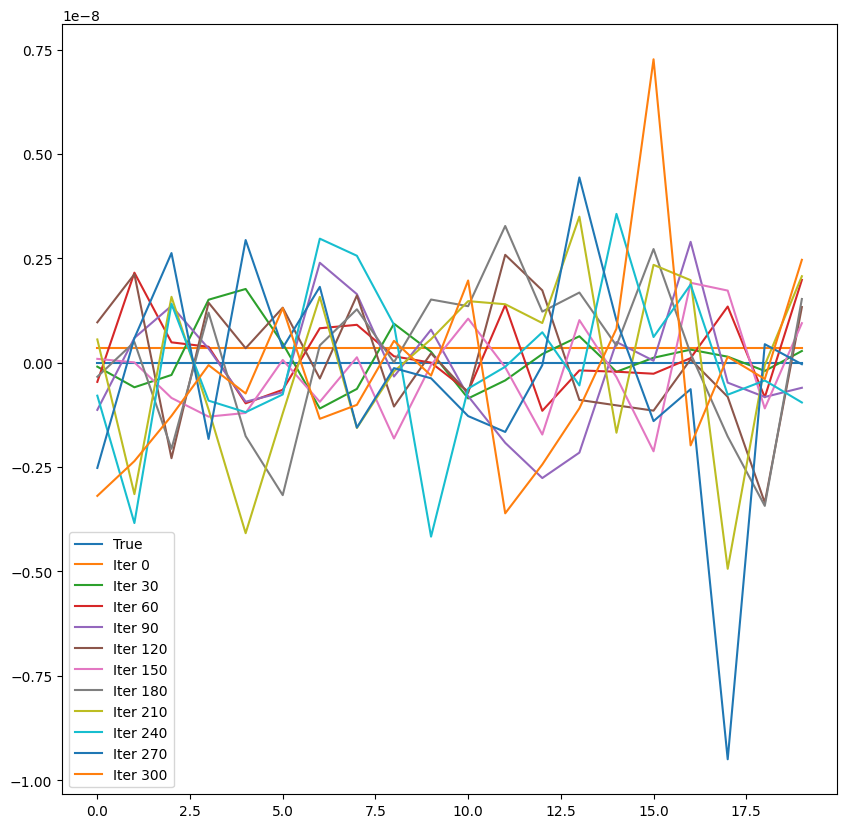

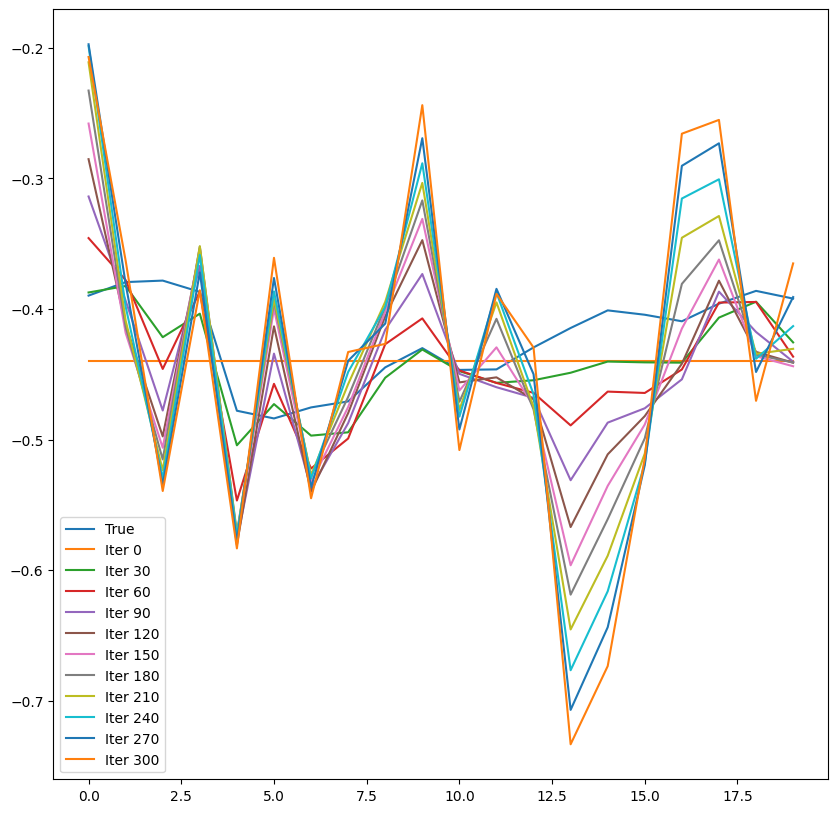

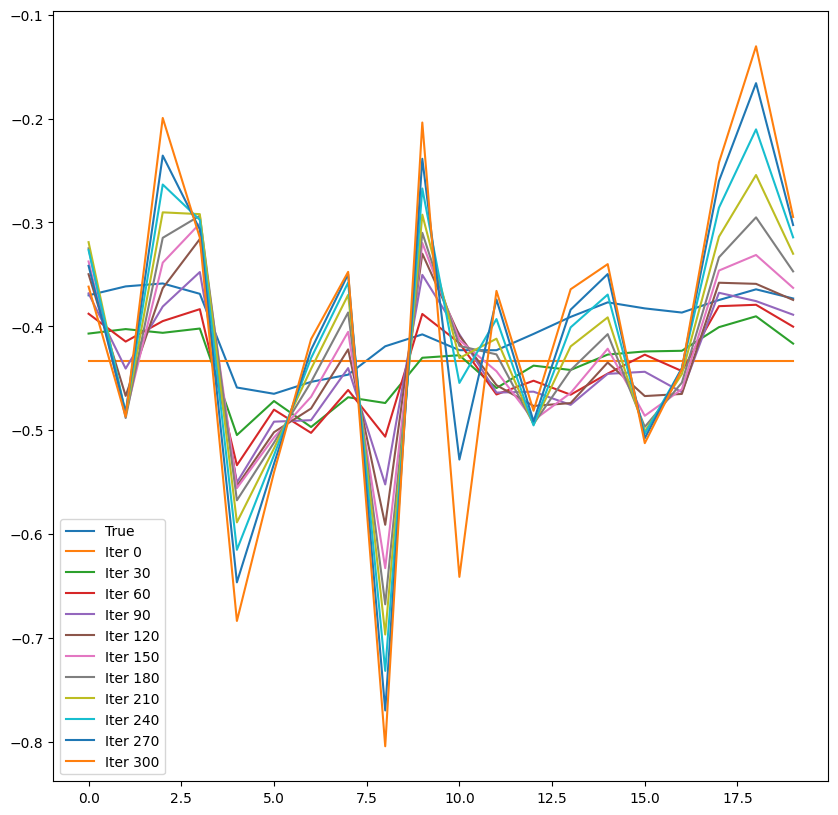

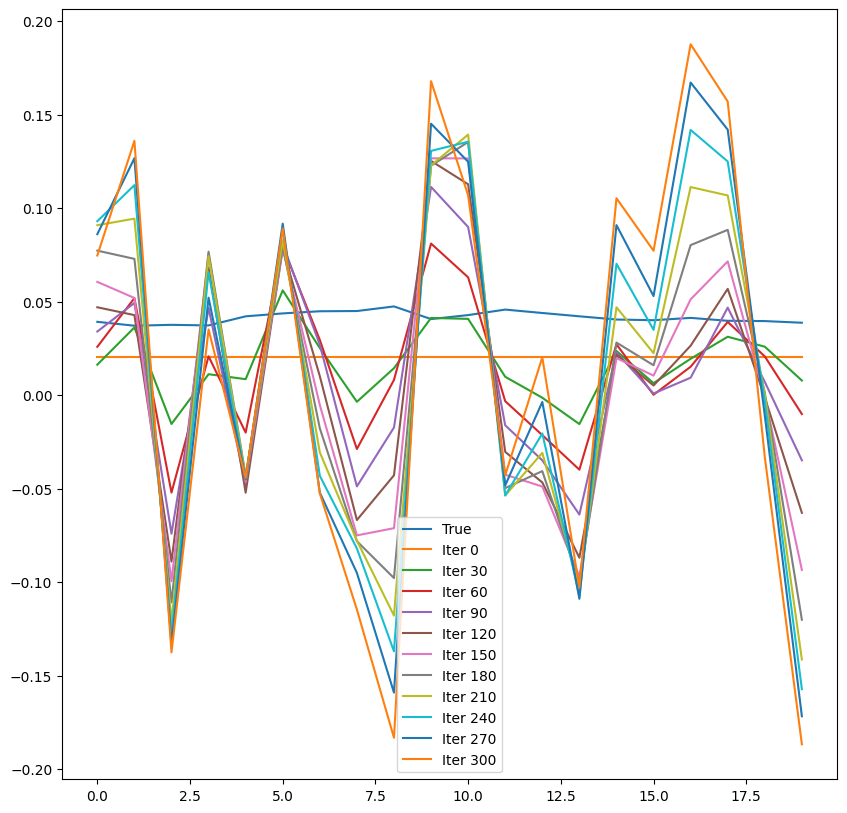

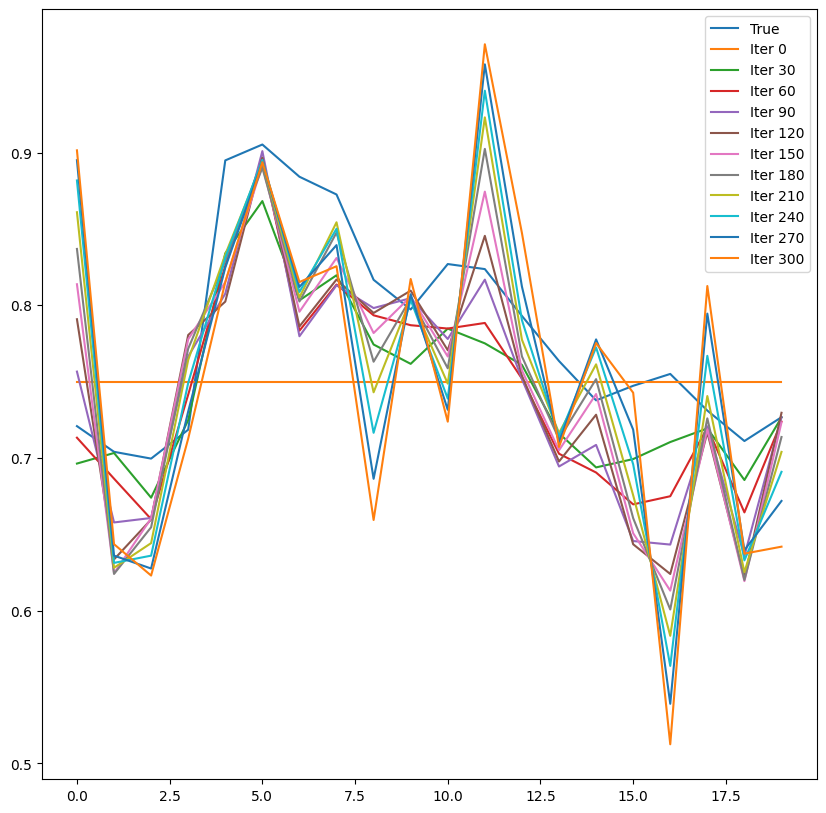

In [ ]:
plt.plot(pinfo_true_restricted[0][0], label="True")
for iter in range(0, pinfo_restricted[0].shape[0], 30):
    plt.plot(pinfo_restricted[0][iter], label=f"Iter {iter}")
plt.legend()
plt.show()

plt.plot(pinfo_true_restricted[1][0], label="True")
for iter in range(0, pinfo_restricted[1].shape[0], 30):
    plt.plot(pinfo_restricted[1][iter], label=f"Iter {iter}")
plt.legend()
plt.show()

plt.plot(pinfo_true_restricted[2][0], label="True")
for iter in range(0, pinfo_restricted[2].shape[0], 30):
    plt.plot(pinfo_restricted[2][iter], label=f"Iter {iter}")
plt.legend()
plt.show()

plt.plot(pinfo_true_restricted[3][0], label="True")
for iter in range(0, pinfo_restricted[3].shape[0], 30):
    plt.plot(pinfo_restricted[3][iter], label=f"Iter {iter}")
plt.legend()
plt.show()

plt.plot(pinfo_true_restricted[4][0], label="True")
for iter in range(0, pinfo_restricted[4].shape[0], 30):
    plt.plot(pinfo_restricted[4][iter], label=f"Iter {iter}")
plt.legend()
plt.show()

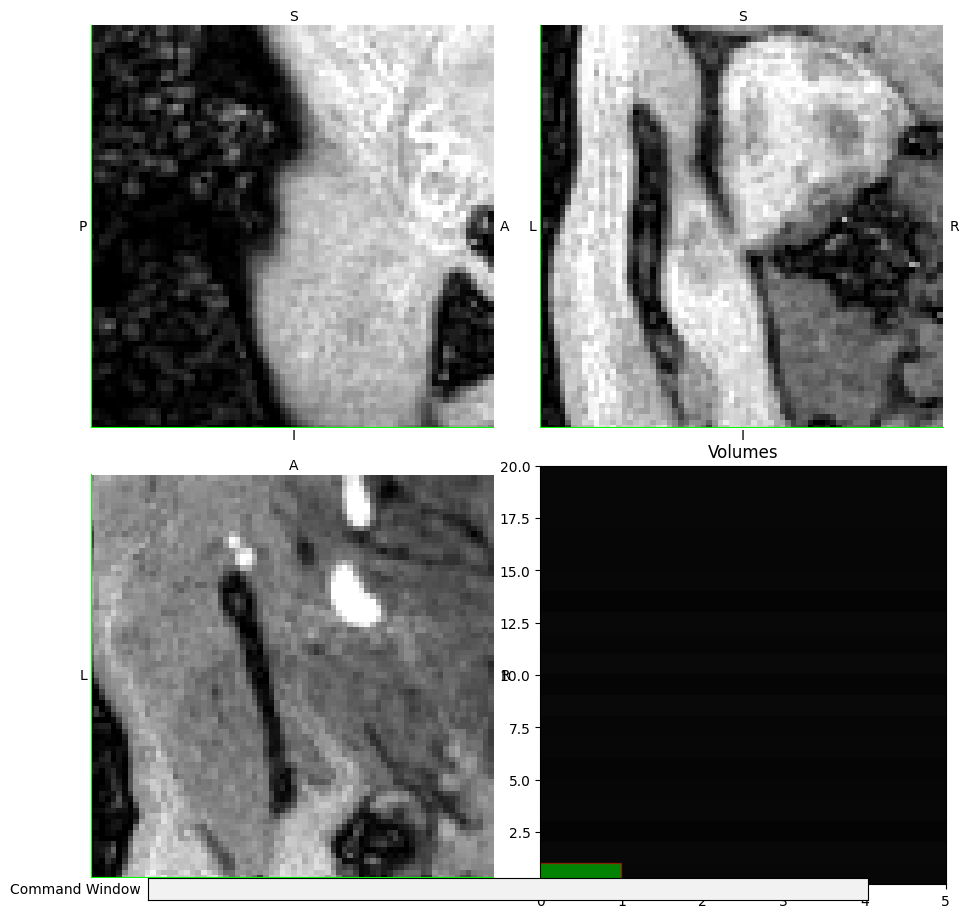

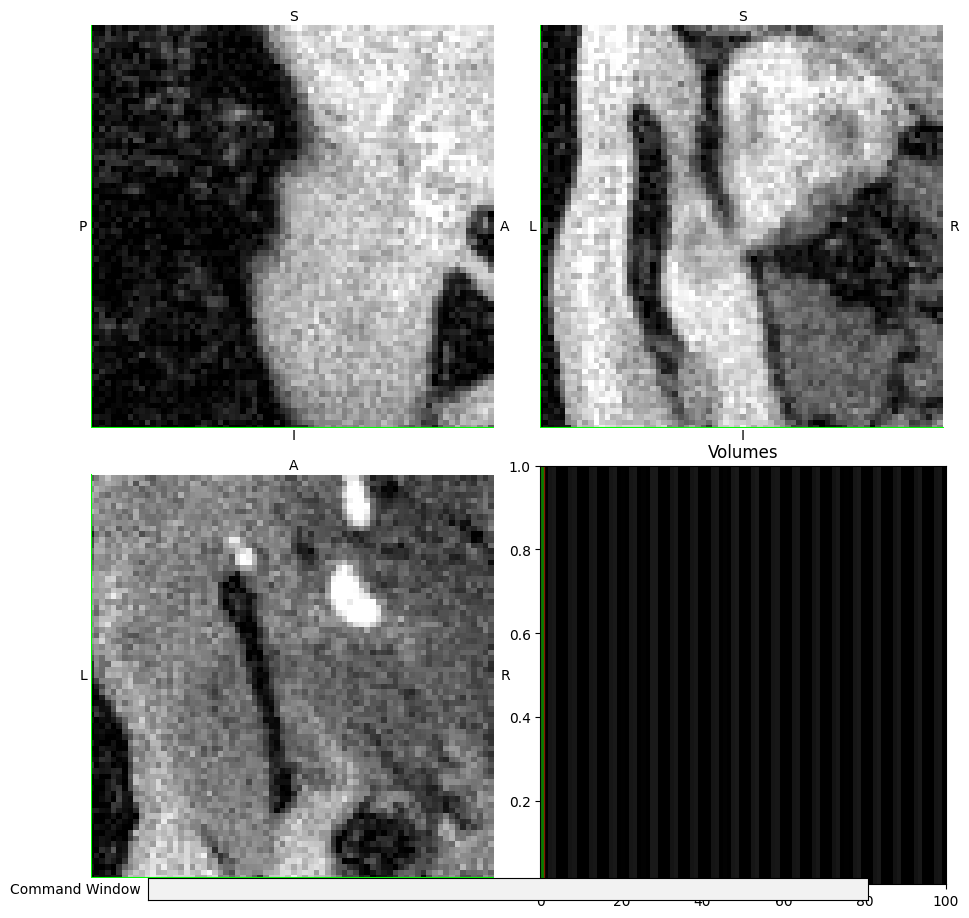

In [ ]:
import orthoslicer as ort

images = imgs(0.5, 5e-1, "mean")

ort.image_nd(true_image)

#ort.image_nd(images[0])
#ort.image_nd(images[1])
ort.image_nd(images[2])